# Dual cAMP–cGMP FRET Pipeline (Spectra → FRET → Simulation → Fit)

This notebook provides a **modular**, end-to-end pipeline to:
1. Load fluorescent protein spectra (ECFP/EYFP/mApple)  
2. Build a FRET forward model (donor excitation, bandpass detection)  
3. Simulate dual messenger dynamics (cAMP/cGMP) with cross-talk  
4. Convert messengers → FRET efficiencies (Hill sensors) → fluorescence channels  
5. Add realistic noise and compute ratiometric signals  
6. Fit model parameters (ODE subset **or** joint ODE + Hill) to ratio data  
7. Plot fits vs data

**Swap in real data** where indicated, keeping the same fitting interface.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# Matplotlib defaults: single-plot figures, no style/colors forced (good for reproducibility)
plt.rcParams.update({
    "figure.dpi": 300,
    "axes.grid": True
})


## Parameter containers

In [2]:

@dataclass
class ODEParams:
    kAC: float = 1.0
    kGC: float = 1.0
    kPDE_A: float = 0.8
    kPDE_G: float = 0.6
    alpha: float = 1.5
    kleak_A: float = 0.05
    kleak_G: float = 0.05

@dataclass
class SensorParams:
    # Hill parameters for cAMP and cGMP sensors
    E0_A: float = 0.15; Emax_A: float = 0.35; K_A: float = 0.5; n_A: float = 2.0
    E0_G: float = 0.10; Emax_G: float = 0.25; K_G: float = 0.5; n_G: float = 2.0

@dataclass
class DetectionParams:
    lambda_ex_D: float = 430.0
    donor_em_center: float = 475.0; donor_em_width: float = 30.0
    acceptor_em_center: float = 535.0; acceptor_em_width: float = 30.0
    red_em_center: float = 600.0; red_em_width: float = 40.0
    kD_A: float = 1.0; kA_A: float = 1.0
    kD_G: float = 1.0; kA_G: float = 1.0
    beta_Y: float = 0.05  # YFP direct excitation under donor-ex
    beta_R: float = 0.02  # mApple direct excitation under donor-ex
    bg: float = 0.02      # background offset


## Spectra utilities

In [3]:

def load_spectra(path: str) -> pd.DataFrame:
    spec = pd.read_csv(path)
    # try to ensure numeric for spectra columns
    for c in spec.columns:
        if c != "wavelength":
            spec[c] = pd.to_numeric(spec[c], errors="coerce").fillna(0.0)
    return spec

def normalize(vec: np.ndarray) -> np.ndarray:
    m = np.max(vec) if np.size(vec)>0 else 0.0
    return vec/(m if m>0 else 1.0)

def sample_at(wavelengths: np.ndarray, spectrum: np.ndarray, lam: float) -> float:
    idx = np.argmin(np.abs(wavelengths - lam))
    return float(spectrum[idx])

def bandpass_integral(wavelengths: np.ndarray, spectrum: np.ndarray, center: float, width: float) -> float:
    lo, hi = center - width/2, center + width/2
    mask = (wavelengths >= lo) & (wavelengths <= hi)
    if not np.any(mask): return 0.0
    return float(np.trapz(spectrum[mask], wavelengths[mask]))


## Messenger ODE model

In [4]:

def pulses(t: float, on: float, off: float) -> float:
    return 1.0 if (on <= t <= off) else 0.0

def rhs(t: float, y: Tuple[float,float], p: ODEParams) -> Tuple[float,float]:
    A, G = y
    uAC = pulses(t, 30, 120)   # AC stimulus
    uGC = pulses(t, 60, 150)   # GC stimulus
    dA = p.kAC*uAC - p.kPDE_A*(1 + p.alpha*G)*A - p.kleak_A*A
    dG = p.kGC*uGC - p.kPDE_G*G - p.kleak_G*G
    return [dA, dG]

def simulate_ode(t_eval: np.ndarray, p: ODEParams, y0=(0.0,0.0)) -> Tuple[np.ndarray,np.ndarray]:
    sol = solve_ivp(lambda t, y: rhs(t, y, p), [t_eval.min(), t_eval.max()], y0, t_eval=t_eval)
    return sol.y  # (2, T) array: rows are A, G


## Sensor (Hill) and FRET forward model

In [5]:

def hill_array(x: np.ndarray, E0: float, Emax: float, K: float, n: float) -> np.ndarray:
    x = np.maximum(x, 0.0)
    return E0 + Emax * (x**n) / (K**n + x**n + 1e-12)

def compute_efficiencies(A: np.ndarray, G: np.ndarray, sp: SensorParams) -> Tuple[np.ndarray,np.ndarray]:
    EA = hill_array(A, sp.E0_A, sp.Emax_A, sp.K_A, sp.n_A)
    EG = hill_array(G, sp.E0_G, sp.Emax_G, sp.K_G, sp.n_G)
    return EA, EG

def prepare_detection_constants(spec: pd.DataFrame, dp: DetectionParams) -> Dict[str, float]:
    w = spec["wavelength"].values.astype(float)
    get = lambda name: normalize(spec[name].values.astype(float))
    ECFP_ex, ECFP_em = get("ECFP ex"), get("ECFP em")
    EYFP_ex, EYFP_em = get("EYFP ex"), get("EYFP em")
    mApple_ex, mApple_em = get("mApple ex"), get("mApple em")

    Ex_D      = sample_at(w, ECFP_ex, dp.lambda_ex_D)
    Ex_A_at_D = sample_at(w, EYFP_ex,  dp.lambda_ex_D)
    Ex_R_at_D = sample_at(w, mApple_ex, dp.lambda_ex_D)

    Em_D_band = bandpass_integral(w, ECFP_em, dp.donor_em_center, dp.donor_em_width)
    Em_A_band = bandpass_integral(w, EYFP_em,  dp.acceptor_em_center, dp.acceptor_em_width)
    Em_R_band = bandpass_integral(w, mApple_em, dp.red_em_center, dp.red_em_width)

    return dict(Ex_D=Ex_D, Ex_A_at_D=Ex_A_at_D, Ex_R_at_D=Ex_R_at_D,
                Em_D_band=Em_D_band, Em_A_band=Em_A_band, Em_R_band=Em_R_band)

def forward_fret(EA: np.ndarray, EG: np.ndarray, const: Dict[str,float], dp: DetectionParams):
    Ex_D, Ex_A_at_D, Ex_R_at_D = const["Ex_D"], const["Ex_A_at_D"], const["Ex_R_at_D"]
    Em_D_band, Em_A_band, Em_R_band = const["Em_D_band"], const["Em_A_band"], const["Em_R_band"]

    F_A_DD = dp.kD_A * ((1 - EA) * Ex_D * Em_D_band) + dp.bg
    F_A_DA = dp.kA_A * (EA * Ex_D * Em_A_band + dp.beta_Y * Ex_A_at_D * Em_A_band) + dp.bg

    F_G_DD = dp.kD_G * ((1 - EG) * Ex_D * Em_D_band) + dp.bg
    F_G_DA = dp.kA_G * (EG * Ex_D * Em_R_band + dp.beta_R * Ex_R_at_D * Em_R_band) + dp.bg

    return F_A_DD, F_A_DA, F_G_DD, F_G_DA

def add_noise(x: np.ndarray, rel: float=0.01, absn: float=0.003, seed: int=42) -> np.ndarray:
    rng = np.random.default_rng(seed)
    return x + rng.normal(0, rel*np.maximum(x,1e-6) + absn, size=x.shape)

def ratios(F_A_DD, F_A_DA, F_G_DD, F_G_DA):
    return F_A_DA/F_A_DD, F_G_DA/F_G_DD


## Fitting utilities

In [6]:

def simulate_ratios_from_params(t_eval: np.ndarray, ode_p: ODEParams, sens_p: SensorParams,
                                const: Dict[str,float], det_p: DetectionParams,
                                y0=(0.0,0.0)) -> Tuple[np.ndarray,np.ndarray]:
    A, G = simulate_ode(t_eval, ode_p, y0=y0)
    EA, EG = compute_efficiencies(A, G, sens_p)
    F_A_DD, F_A_DA, F_G_DD, F_G_DA = forward_fret(EA, EG, const, det_p)
    return ratios(F_A_DD, F_A_DA, F_G_DD, F_G_DA)

def fit_subset_ode_params(t_eval, R_A_obs, R_G_obs, ode_seed: ODEParams, sens_p: SensorParams,
                          const, det_p: DetectionParams):
    # Fit [kAC, kGC, alpha] keeping the rest fixed
    fixed = dict(kPDE_A=ode_seed.kPDE_A, kPDE_G=ode_seed.kPDE_G, kleak_A=ode_seed.kleak_A, kleak_G=ode_seed.kleak_G)
    def residuals(theta):
        kAC, kGC, alpha = theta
        ode_try = ODEParams(kAC=kAC, kGC=kGC, alpha=alpha, **fixed)
        RA, RG = simulate_ratios_from_params(t_eval, ode_try, sens_p, const, det_p)
        return np.concatenate([RA - R_A_obs, RG - R_G_obs])
    x0 = np.array([ode_seed.kAC, ode_seed.kGC, ode_seed.alpha])
    bnds = (np.zeros_like(x0), np.ones_like(x0)*5.0)
    res = least_squares(residuals, x0, bounds=bnds, xtol=1e-8, ftol=1e-8)
    return res.x, res

def fit_joint_ode_hill(t_eval, R_A_obs, R_G_obs, ode_seed: ODEParams, sens_seed: SensorParams, const, det_p: DetectionParams):
    # theta = [kAC, kGC, alpha, E0_A, Emax_A, K_A, n_A, E0_G, Emax_G, K_G, n_G]
    def pack(ode_p: ODEParams, s: SensorParams):
        return np.array([ode_p.kAC, ode_p.kGC, ode_p.alpha,
                         s.E0_A, s.Emax_A, s.K_A, s.n_A, s.E0_G, s.Emax_G, s.K_G, s.n_G], dtype=float)
    def unpack(theta):
        kAC, kGC, alpha, E0A, EmaxA, KA, nA, E0G, EmaxG, KG, nG = theta
        ode = ODEParams(kAC=kAC, kGC=kGC, alpha=alpha,
                        kPDE_A=ode_seed.kPDE_A, kPDE_G=ode_seed.kPDE_G,
                        kleak_A=ode_seed.kleak_A, kleak_G=ode_seed.kleak_G)
        sens = SensorParams(E0_A=E0A, Emax_A=EmaxA, K_A=KA, n_A=nA,
                            E0_G=E0G, Emax_G=EmaxG, K_G=KG, n_G=nG)
        return ode, sens

    theta0 = pack(ode_seed, sens_seed)
    lb = np.array([0,0,0, 0,0,1e-3,1.0, 0,0,1e-3,1.0], dtype=float)
    ub = np.array([5,5,5, 0.6,0.8,5.0,4.0, 0.6,0.8,5.0,4.0], dtype=float)

    def residuals(theta):
        ode_try, sens_try = unpack(theta)
        RA, RG = simulate_ratios_from_params(t_eval, ode_try, sens_try, const, det_p)
        return np.concatenate([RA - R_A_obs, RG - R_G_obs])

    res = least_squares(residuals, theta0, bounds=(lb,ub), xtol=1e-8, ftol=1e-8)
    ode_hat, sens_hat = unpack(res.x)
    return (ode_hat, sens_hat), res


## Plotting utilities

In [7]:

def plot_messengers(t, A, G, title="Underlying messengers"):
    plt.figure()
    plt.plot(t, A, label="cAMP")
    plt.plot(t, G, label="cGMP")
    plt.xlabel("time"); plt.ylabel("concentration-like")
    plt.title(title); plt.legend(); plt.show()

def plot_ratios_vs_fit(t, RA_obs, RG_obs, RA_fit, RG_fit):
    plt.figure()
    plt.plot(t, RA_obs, 'o', ms=2, alpha=0.6, label="R_A observed")
    plt.plot(t, RA_fit, '-', lw=2, label="R_A fit")
    plt.xlabel("time"); plt.ylabel("FRET ratio (cAMP sensor)")
    plt.title("cAMP FRET ratio: data vs fit")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(t, RG_obs, 'o', ms=2, alpha=0.6, label="R_G observed")
    plt.plot(t, RG_fit, '-', lw=2, label="R_G fit")
    plt.xlabel("time"); plt.ylabel("FRET ratio (cGMP sensor)")
    plt.title("cGMP FRET ratio: data vs fit")
    plt.legend(); plt.show()


## Demo: simulate synthetic ratios, fit parameters, and plot

/tmp/ipykernel_18432/448965131.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(spectrum[mask], wavelengths[mask]))


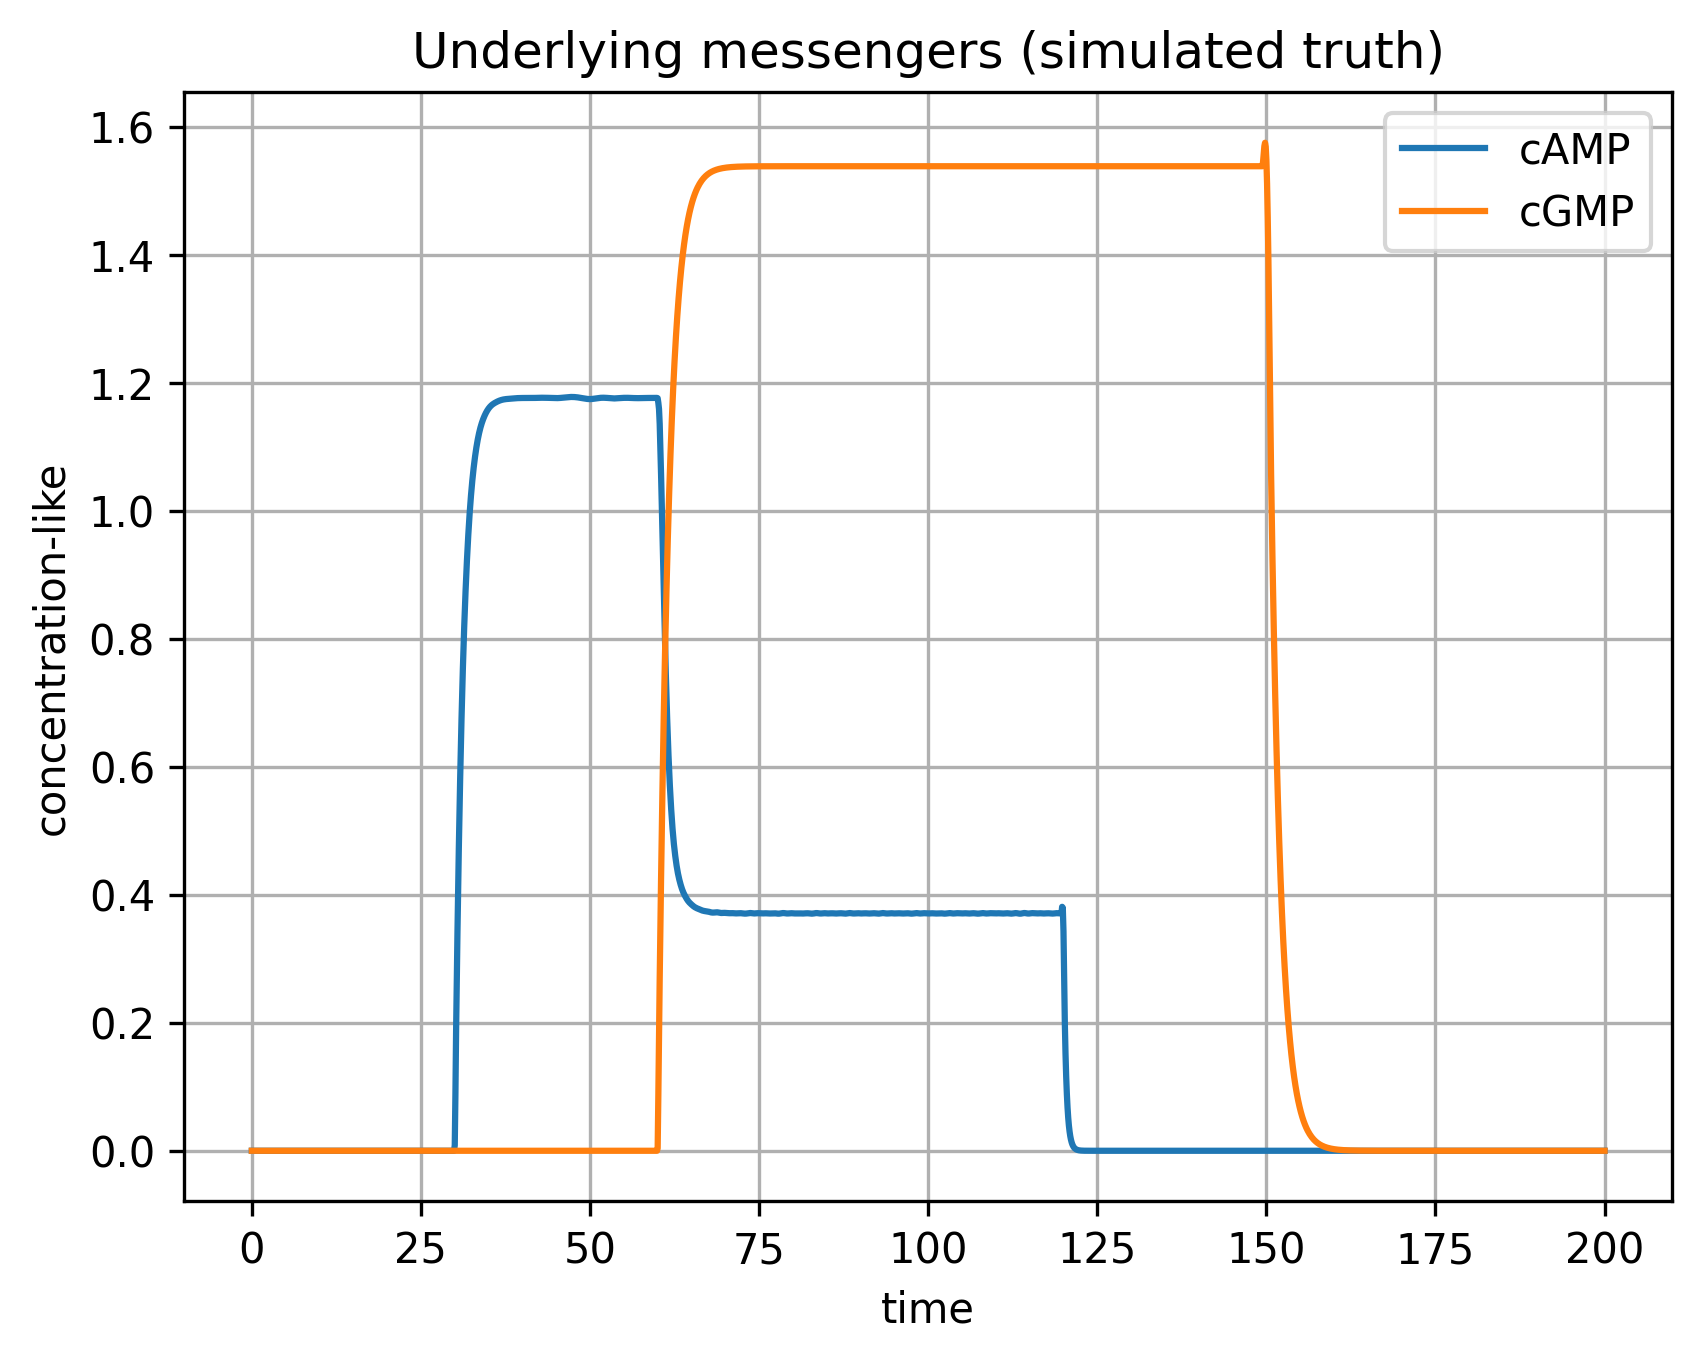

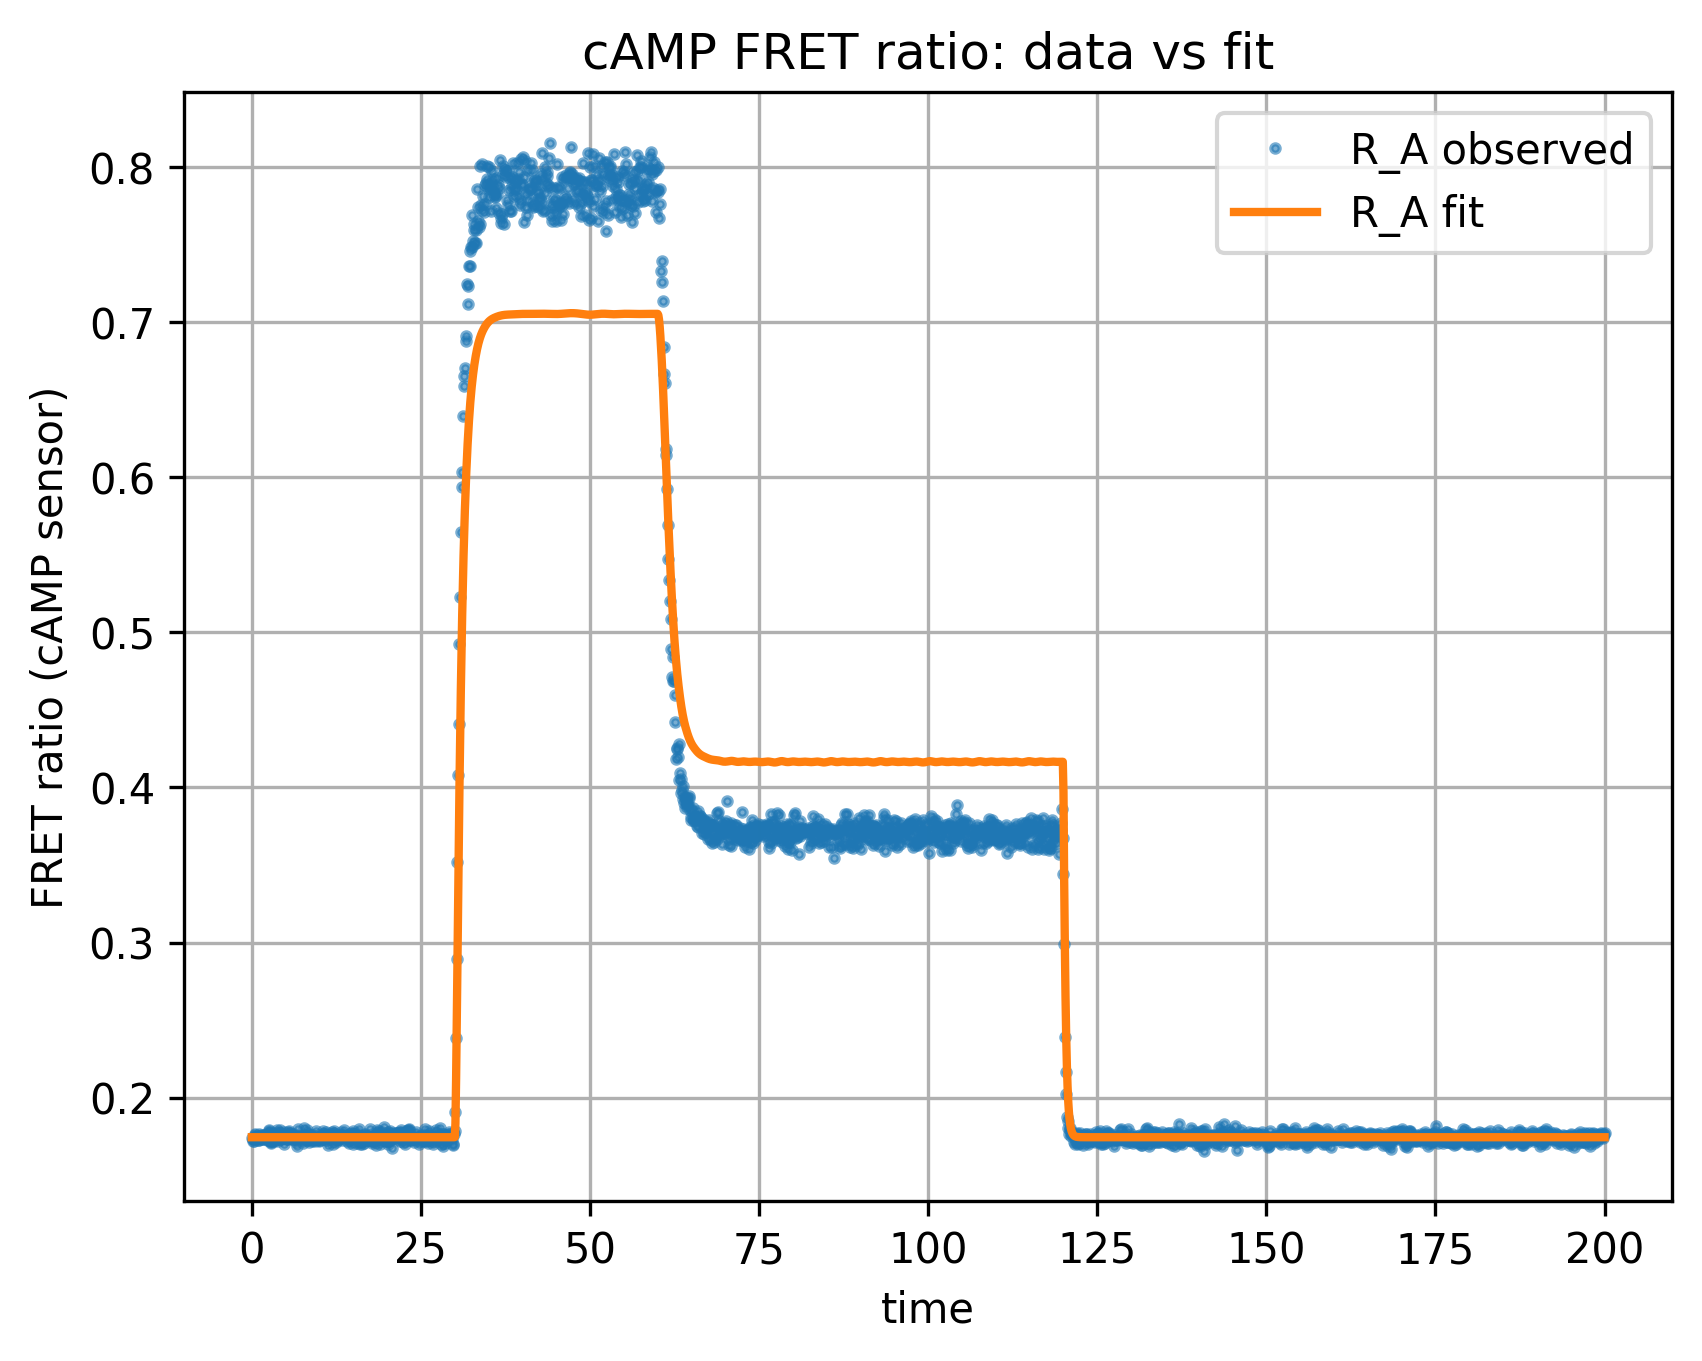

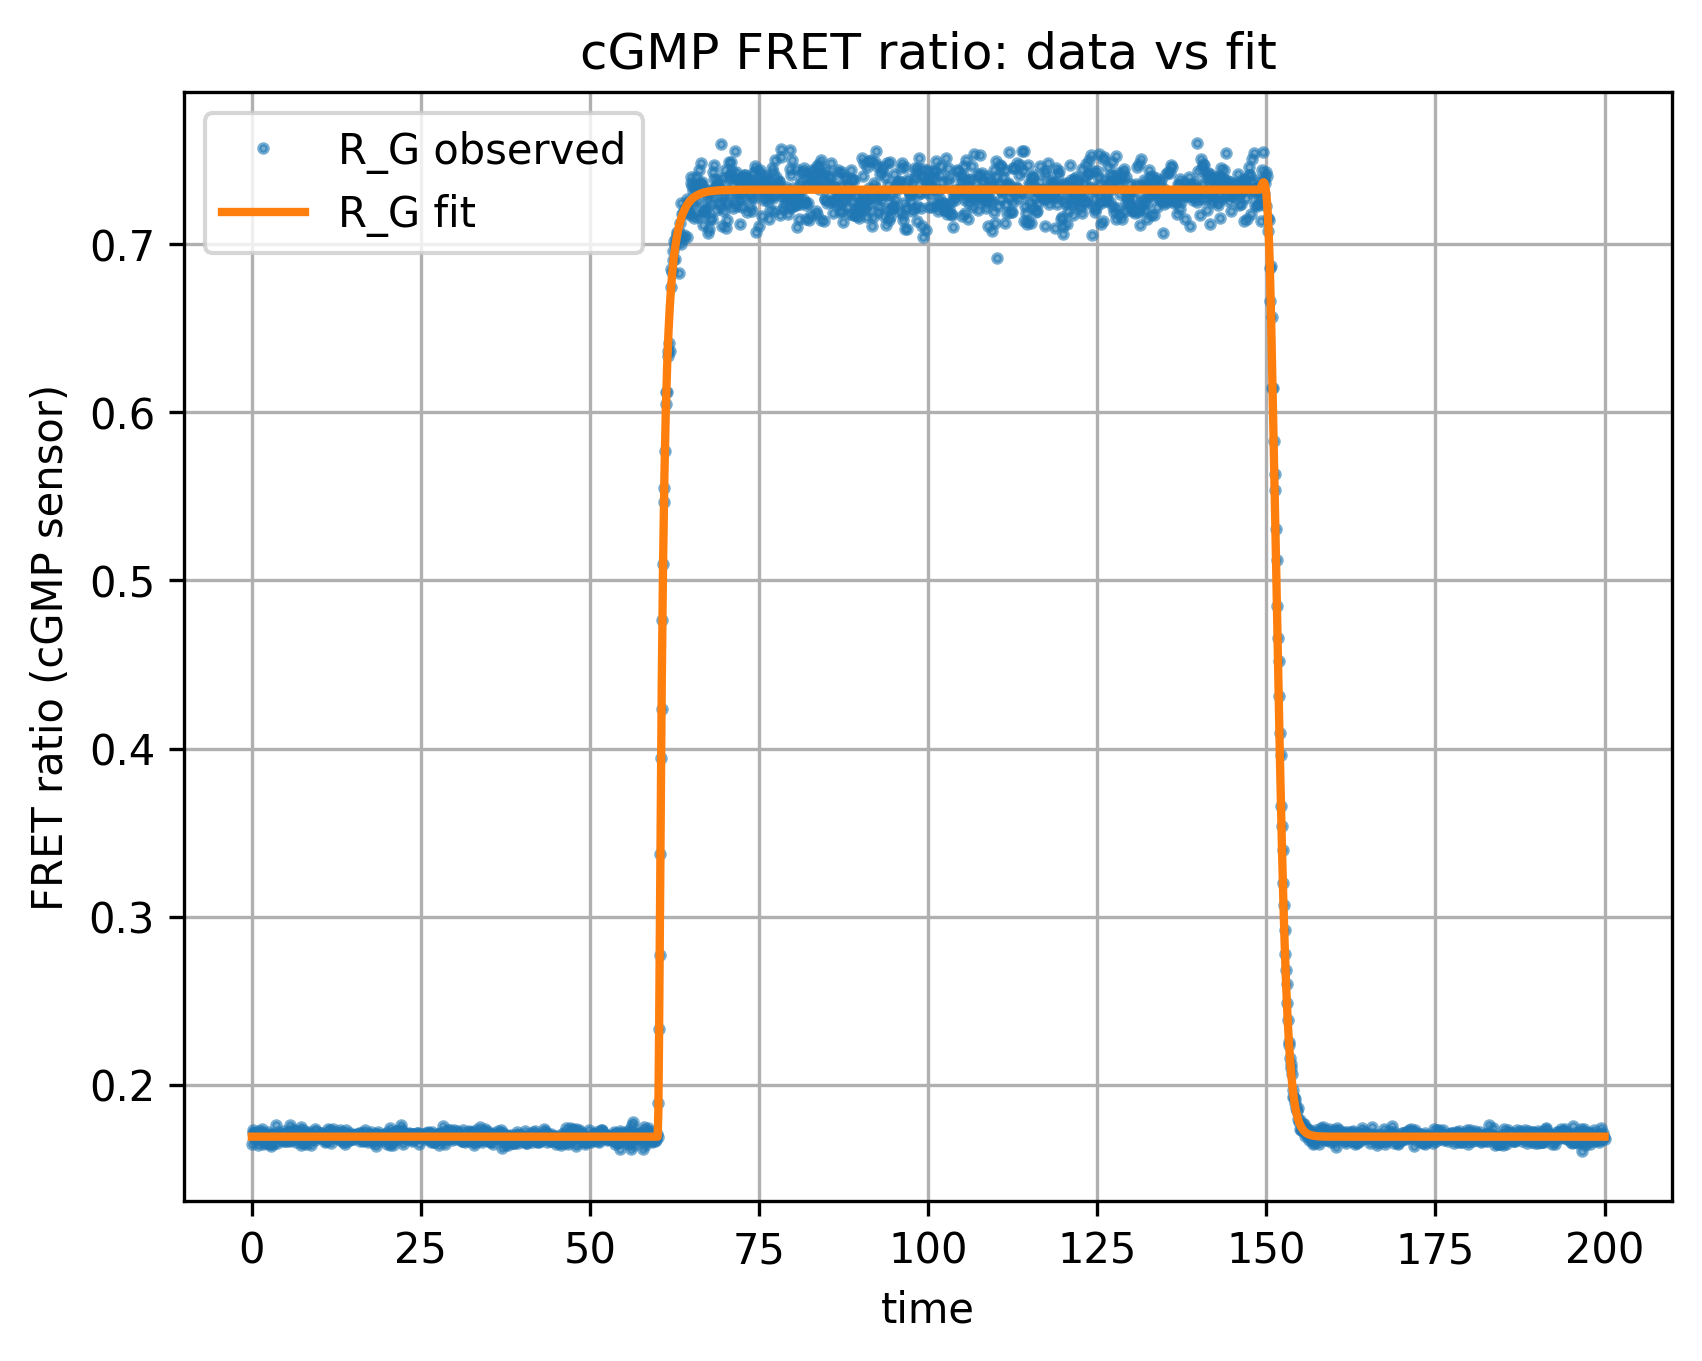

Subset ODE fit [kAC, kGC, alpha]: [0.77575948 1.00627861 0.77522053]


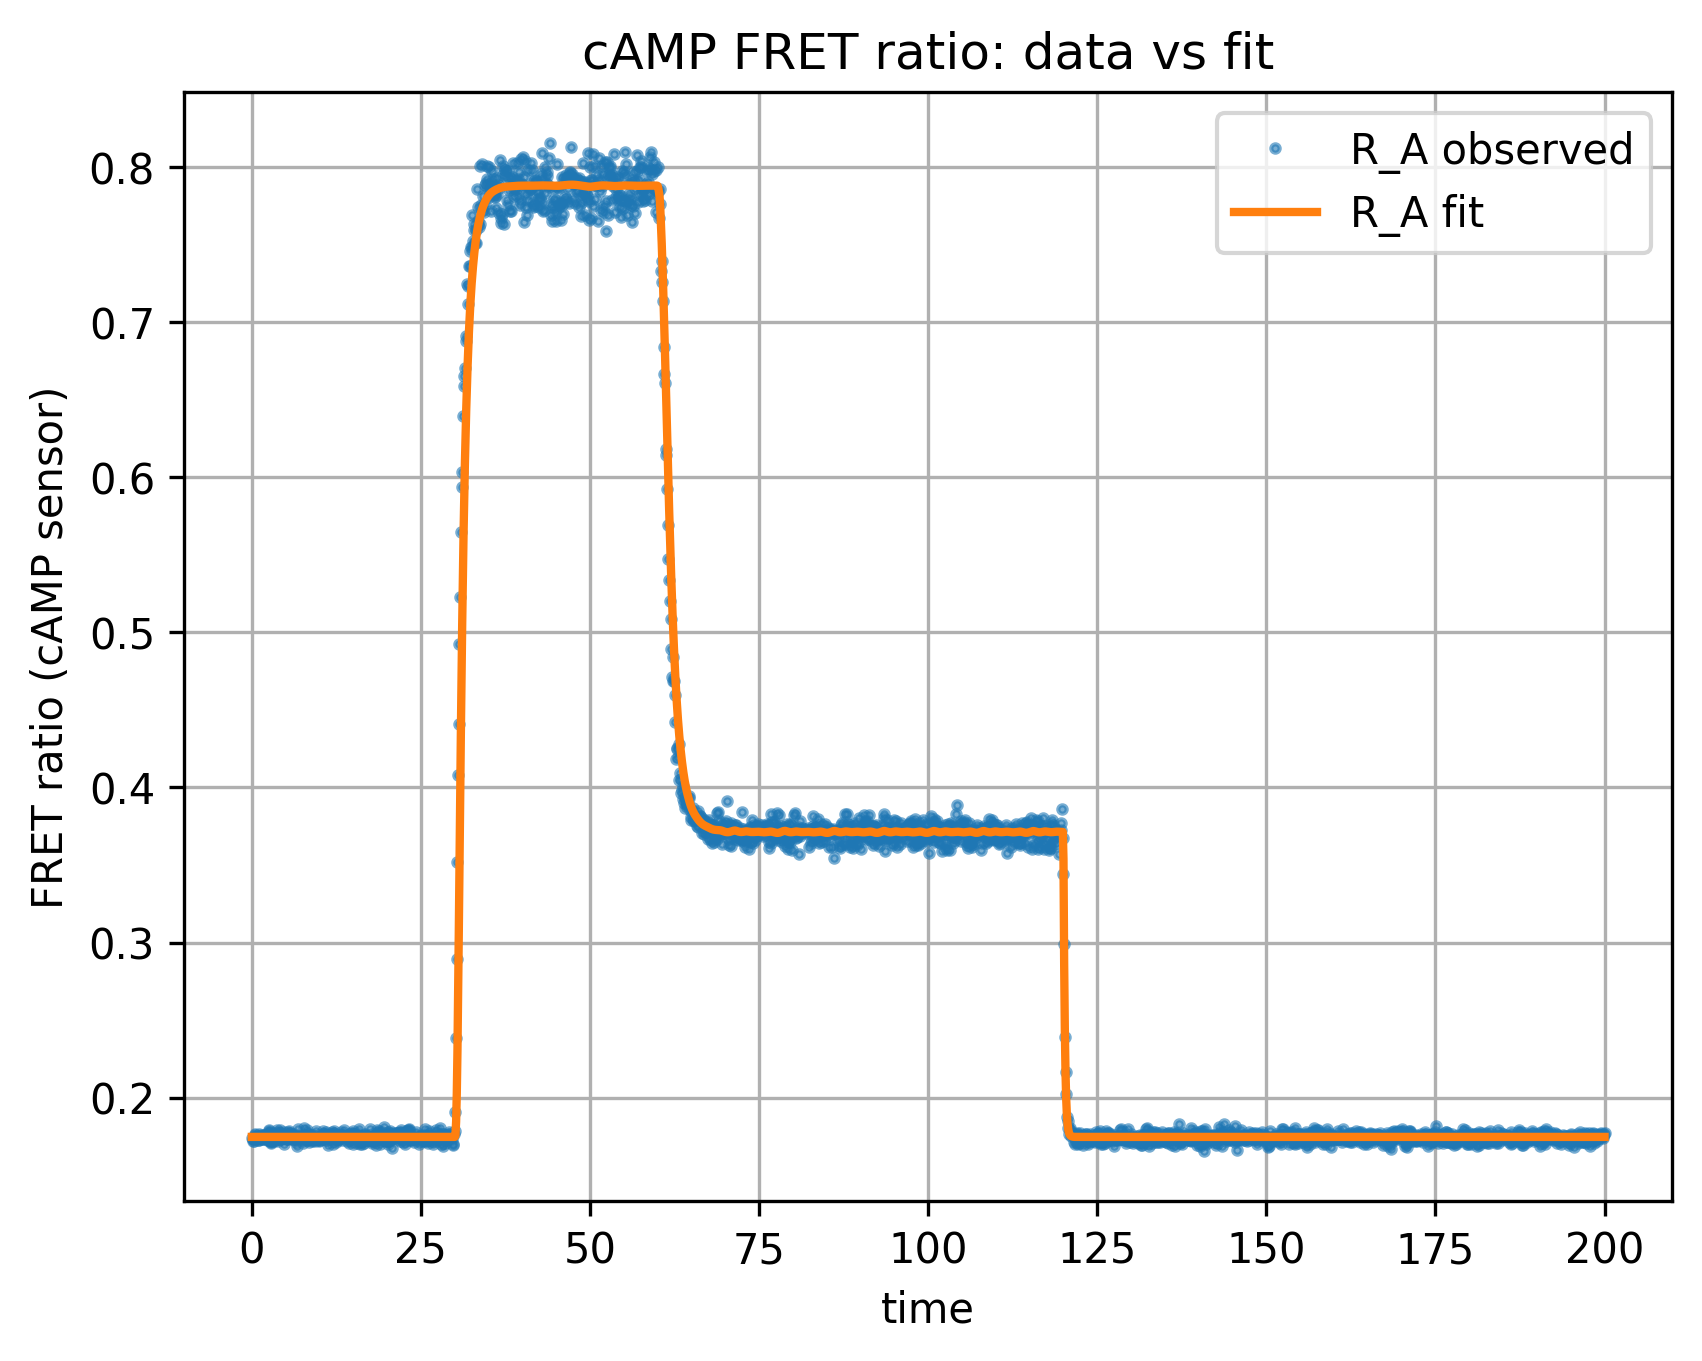

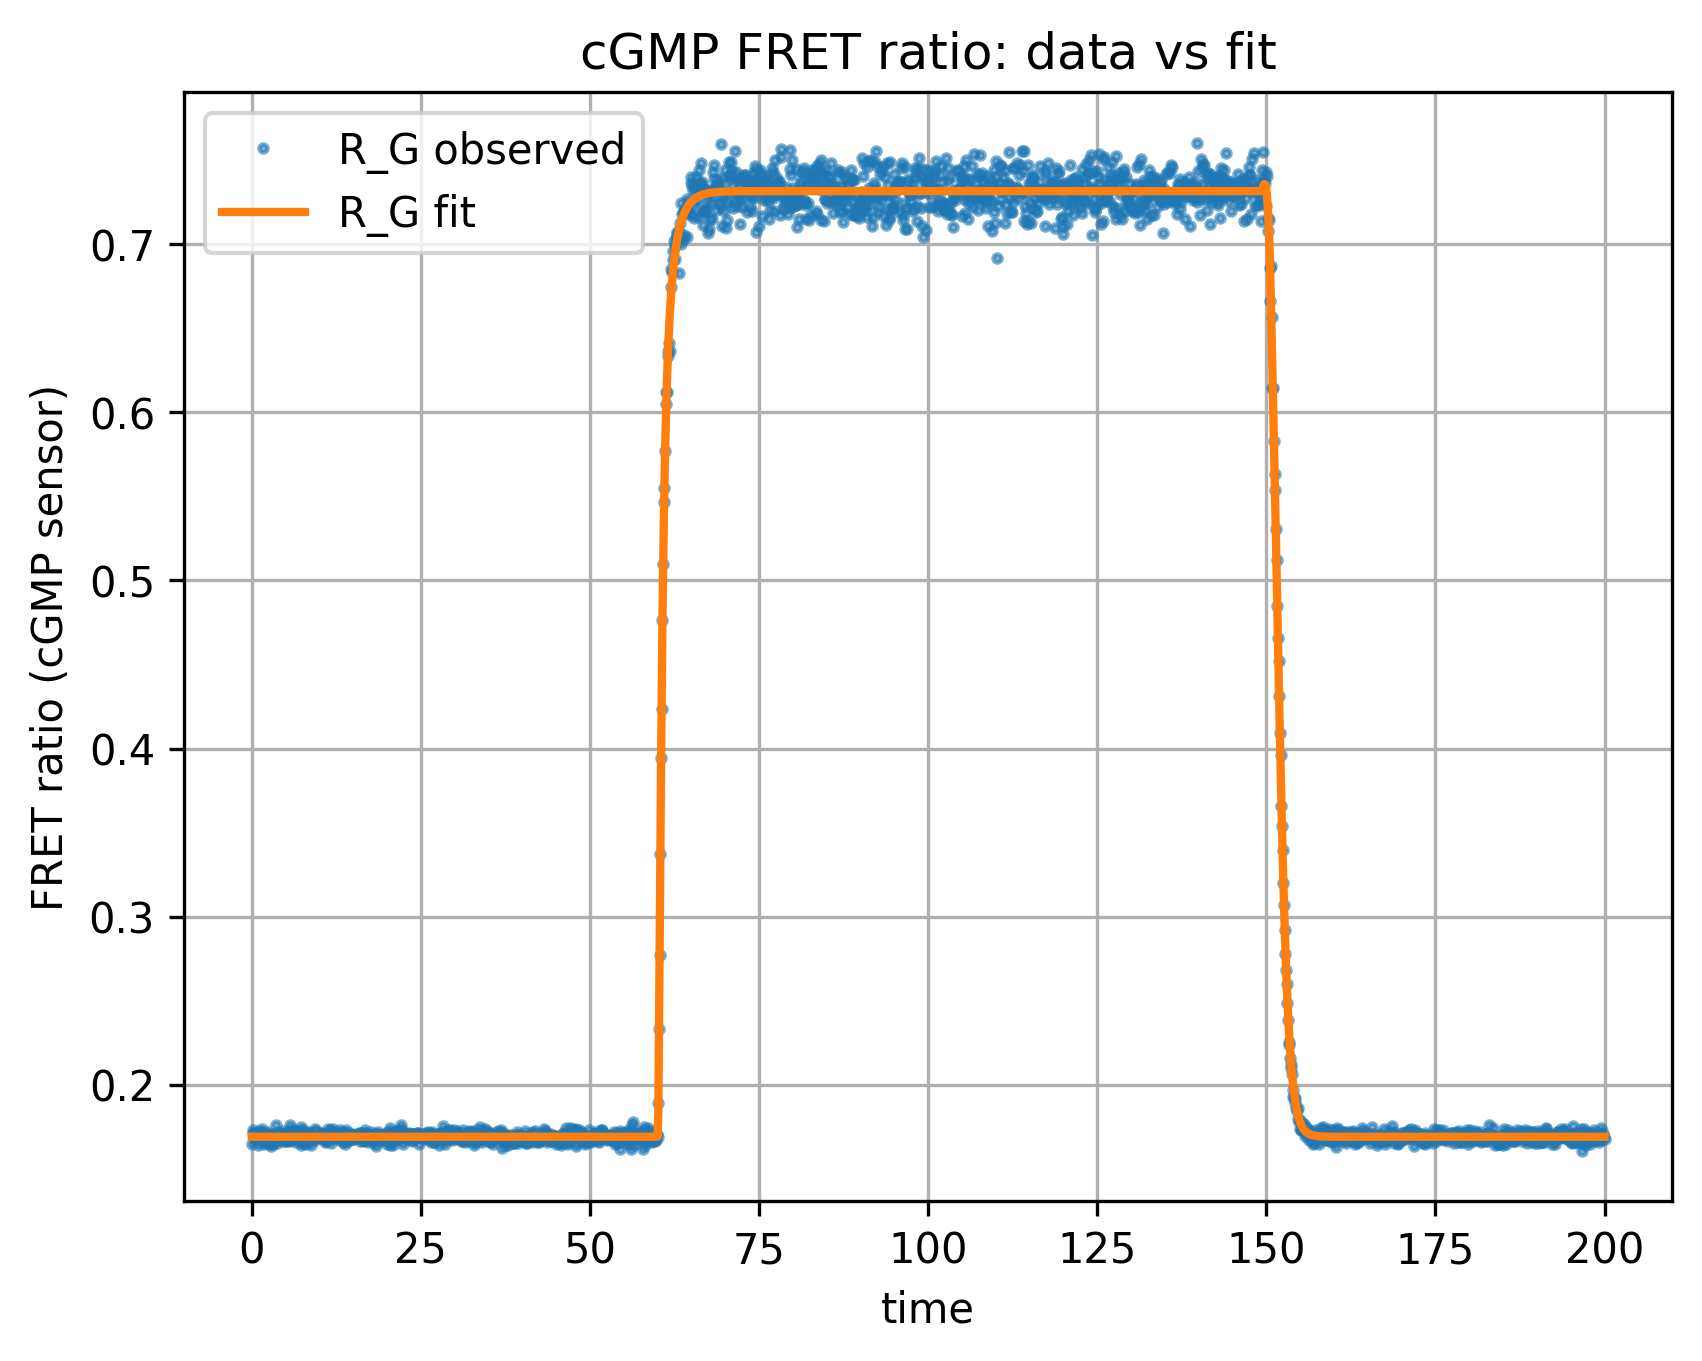

Joint ODE+Hill fit:
ODEParams(kAC=np.float64(1.0255667377672595), kGC=np.float64(0.8972626299294124), kPDE_A=0.8, kPDE_G=0.6, alpha=np.float64(0.8612407203063341), kleak_A=0.05, kleak_G=0.05)
SensorParams(E0_A=np.float64(0.15015274879872129), Emax_A=np.float64(0.3528748488863145), K_A=np.float64(0.6964721222791476), n_A=np.float64(3.016038093237499), E0_G=np.float64(0.09998698284132124), Emax_G=np.float64(0.25308210936243325), K_G=np.float64(0.4586763819072839), n_G=np.float64(1.9309721452533775))


In [8]:

# Load spectra from the uploaded file
spec_path = "data/fpbase_spectra.csv"
spec = load_spectra(spec_path)

# Prepare constants
det_p = DetectionParams()
const = prepare_detection_constants(spec, det_p)

# Truth for simulation
ode_true = ODEParams(kAC=1.0, kGC=1.0, kPDE_A=0.8, kPDE_G=0.6, alpha=1.5, kleak_A=0.05, kleak_G=0.05)
sens_true = SensorParams(E0_A=0.15, Emax_A=0.35, K_A=0.5, n_A=2.0,
                         E0_G=0.10, Emax_G=0.25, K_G=0.5, n_G=2.0)

# Simulate and create noisy ratio observations
t_eval = np.linspace(0, 200, 2001)
A, G = simulate_ode(t_eval, ode_true, y0=(0.0,0.0))
EA, EG = compute_efficiencies(A, G, sens_true)
F_A_DD, F_A_DA, F_G_DD, F_G_DA = forward_fret(EA, EG, const, det_p)

F_A_DD_obs = add_noise(F_A_DD, seed=1)
F_A_DA_obs = add_noise(F_A_DA, seed=2)
F_G_DD_obs = add_noise(F_G_DD, seed=3)
F_G_DA_obs = add_noise(F_G_DA, seed=4)
R_A_obs, R_G_obs = ratios(F_A_DD_obs, F_A_DA_obs, F_G_DD_obs, F_G_DA_obs)

# Plot messengers (truth)
plot_messengers(t_eval, A, G, title="Underlying messengers (simulated truth)")

# --- Subset ODE fit ---
ode_seed = ODEParams(kAC=0.8, kGC=0.8, kPDE_A=0.8, kPDE_G=0.6, alpha=1.0, kleak_A=0.05, kleak_G=0.05)
subset_params, subset_res = fit_subset_ode_params(t_eval, R_A_obs, R_G_obs, ode_seed, sens_true, const, det_p)
ode_subset = ODEParams(kAC=subset_params[0], kGC=subset_params[1], alpha=subset_params[2],
                       kPDE_A=ode_seed.kPDE_A, kPDE_G=ode_seed.kPDE_G, kleak_A=ode_seed.kleak_A, kleak_G=ode_seed.kleak_G)

RA_fit_subset, RG_fit_subset = simulate_ratios_from_params(t_eval, ode_subset, sens_true, const, det_p)
plot_ratios_vs_fit(t_eval, R_A_obs, R_G_obs, RA_fit_subset, RG_fit_subset)

print("Subset ODE fit [kAC, kGC, alpha]:", subset_params)

# --- Joint ODE + Hill fit ---
sens_seed = SensorParams(E0_A=0.10, Emax_A=0.30, K_A=0.7, n_A=2.0,
                         E0_G=0.08, Emax_G=0.20, K_G=0.7, n_G=2.0)

(ode_hat, sens_hat), res_joint = fit_joint_ode_hill(t_eval, R_A_obs, R_G_obs, ode_seed, sens_seed, const, det_p)
RA_fit_joint, RG_fit_joint = simulate_ratios_from_params(t_eval, ode_hat, sens_hat, const, det_p)
plot_ratios_vs_fit(t_eval, R_A_obs, R_G_obs, RA_fit_joint, RG_fit_joint)

print("Joint ODE+Hill fit:")
print(ode_hat)
print(sens_hat)


## Hook for real ratio data

To fit **real** dual-FRET ratio time series, place a CSV with columns like:
```
time_s, R_A, R_G
0.0, 1.02, 0.98
0.1, 1.03, 0.98
...
```
Then replace the synthetic `R_A_obs, R_G_obs` with data-loaded arrays, and call the same fit functions.


In [9]:

# Example loader (uncomment and adapt column names):
# df = pd.read_csv("my_real_dual_fret_ratios.csv")
# t_eval = df["time_s"].values
# R_A_obs = df["R_A"].values
# R_G_obs = df["R_G"].values
# # Then reuse: subset or joint fit methods from above.
